<a href="https://colab.research.google.com/github/tombackert/ml-stuff/blob/main/lime-paper-implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIME using Paper Implementation  


In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=67860416371e8d4033000ba63a5a0f40be5207772ed1bd8326a2b05556f0e695
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [4]:
# Imports
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import os, json

import torch
import torch.nn.functional as F
from torchvision import models, transforms
from torch.autograd import Variable
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [63]:
# Fuction for reading in the images
def get_image(path):
  with open(os.path.abspath(path), 'rb') as f:
    with Image.open(f) as img:
      return img.convert('RGB')

In [64]:
# Paths to images
root = './lime-sample-data'

names = ['./elephant.jpg',
         './964-turbo.jpg',
         './dtm-cars.jpg',
         './sailboat-ibiza.jpg']

paths = [os.path.join(root, name) for name in names]

images = [get_image(path) for path in paths]

In [65]:
# Function for displaying all input images
def show_images(images):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))

    for i, image in enumerate(images):
        axes[i].imshow(image)
        axes[i].axis('on')

    plt.show()

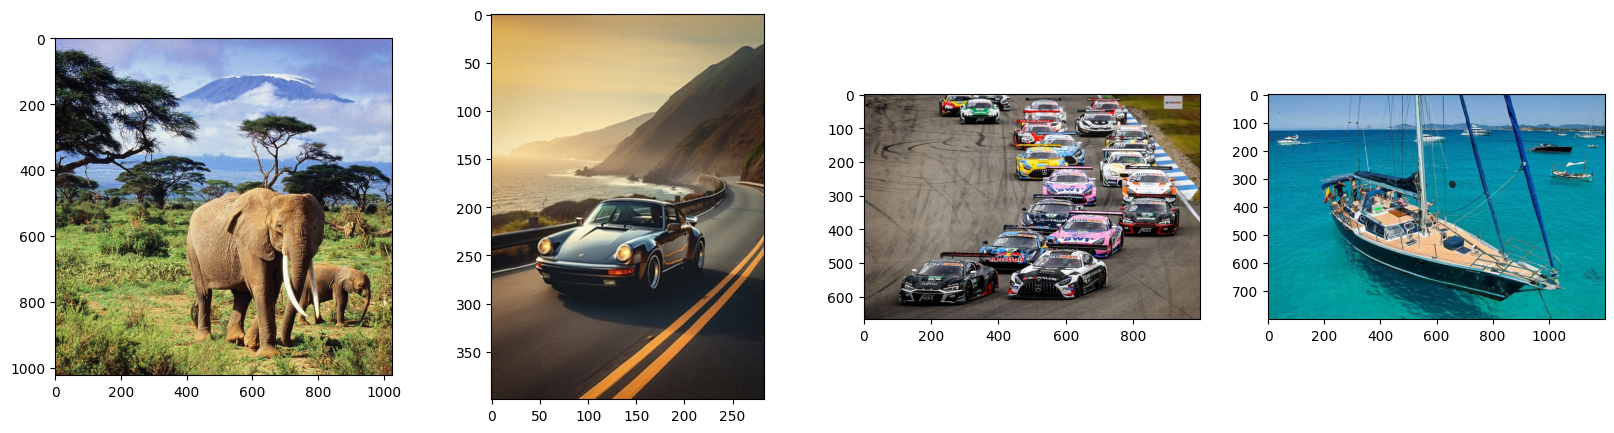

In [66]:
show_images(images)

In [57]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [75]:
# Choose Resnet50 pretrained on ImageNet
model = models.inception_v3(weights=True)

In [60]:
# Load class labels
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('./imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

In [61]:
# Funtion for getting predictions on sample images
def get_predictions(model, img):
    # Get input tensor
    img_t = get_input_tensors(img)

    # Make prediction
    model.eval()
    logits = model(img_t)

    # Get probabilities and top 5 predictions
    probs = F.softmax(logits, dim=1)
    probs5 = probs.topk(5)

    # Convert logits to probabilities and get class labels
    predictions = [(p.item(), c.item(), idx2label[c.item()]) for p, c in zip(probs5[0][0], probs5[1][0])]

    return predictions

In [76]:
# Predictions for the first image
predictions_img = get_predictions(model, images[3])
print(predictions_img)

[(0.7367209792137146, 625, 'lifeboat'), (0.17655253410339355, 914, 'yawl'), (0.03584054484963417, 780, 'schooner'), (0.026929710060358047, 724, 'pirate'), (0.010047804564237595, 576, 'gondola')]


In [16]:
# Function for transforming images to size 224 x 224
def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])

    return transf

# Function for converting images to tensor and normalizing pixel values
def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

In [ ]:
pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [17]:
# Function for getting predictions on sample images
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [80]:
test_preds = batch_predict([pill_transf(img) for img in images])
test_preds.argmax(axis=1)

array([386, 817, 468, 625])

In [19]:
# Generate Lime explanations for each image
def generate_lime_explanations(images, batch_predict, top_labels=5, hide_color=0, num_samples=1000):
  explanations = []
  explainer = lime_image.LimeImageExplainer()

  for img in images:
    explanation = explainer.explain_instance(np.array(img),
                                             batch_predict,
                                             top_labels=top_labels,
                                             hide_color=hide_color,
                                             num_samples=num_samples)
    explanations.append(explanation)

  return explanations

In [20]:
# Lime applied to sample images
explanations = generate_lime_explanations(images, batch_predict)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [92]:
# Choose example explantation
explanation = explanations[1]

In [95]:
# Compare with actual class
print(explanation.top_labels[1])

817


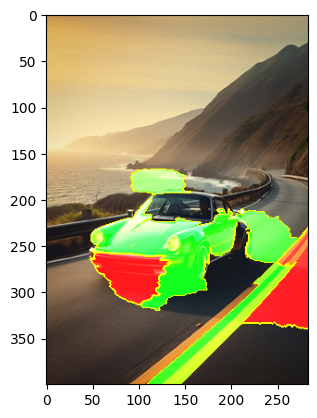

In [96]:
# Show explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=10, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [1]:
# Function for displaying all explanations
def show_explanations():
  num_images = len(explanations)
  num_cols = 4
  num_rows = (num_images + num_cols - 1) // num_cols

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5))

  for i, (explanation, img) in enumerate(zip(explanations, images)):
      row = i // num_cols
      col = i % num_cols

      temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

      img_boundry = mark_boundaries(temp / 255.0, mask)

      axes[row, col].imshow(img_boundry)
      axes[row, col].set_title(f'Image {i+1}')
      axes[row, col].axis('off')

  plt.tight_layout()
  plt.show()

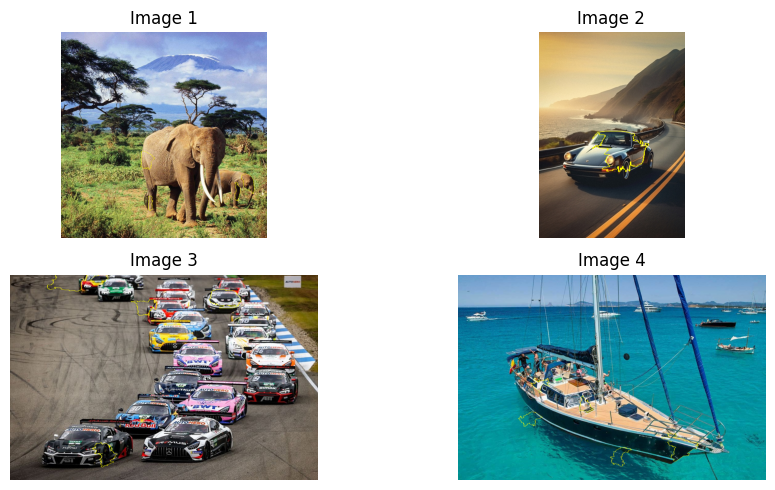

In [28]:
show_explanations()